# **Customer Enquiry ETL Process**

## **Latar Belakang**

Lembaga pendidikan merupakan industri layanan yang berfokus untuk mengembangkan pendidikan. Salah satu rahasia lembaga pendidikan dapat eksis dalam waktu yang lama, yaitu dengan memenangkan kepercayaan dari masyarakat sekitar. Kepercayaan inilah yang memimpin para orangtua untuk mendaftarkan anaknya ke lembaga pendidikan yang dapat membawa perubahan hidup yang lebih baik. Sebagai *data analyst* dalam lembaga pendidikan, saya mencoba untuk mendapatkan informasi dari data percakapan antara **Tim Pendaftaran** dan **calon prospek** agar dapat menghasilkan *tools monitoring* Tim Pendaftaran yang diharapkan dapat meningkatkan konversi *sales*.

## **Tujuan**

Tujuan dari analisis data yaitu:
1. Mengetahui jumlah calon prospek yang tidak melanjutkan *enquiry* (*lost customers*)
2. Mengetahui produk dan cabang yang paling diminati oleh calon prospek
3. Melakukan klasifikasi calon prospek berdasarkan percakapan

In [834]:
# import library
import time
start_times = time.time()

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

import gspread
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from io import BytesIO

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 500)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

## ***Data Extract***
- Proses ekstrak data dilakukan dengan *import* data dari *Relational Database System* (RDBS) atau tempat penyimpanan tertentu.
- Ekstrak data pada proyek ini mengambil data yang tersimpan dalam *Google Drive* menggunakan *Google API*.
- Pemasangan *Google API* dilakukan dengan membuat proyek pada *Google Cloud Console*, kemudian mengunduh kredensial untuk otentikasi akses.
- Proses pengunduhan data dilakukan dengan menyertakan nama file serta folder tempat file tersebut tersimpan.

In [835]:
# Path ke service account
SERVICE_ACCOUNT_FILE = 'customer-enquiry-431809-2ffbd2f82785.json'

# Scope API
SCOPES = ['https://www.googleapis.com/auth/drive']

# Otentikasi dan pembuatan service
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('drive', 'v3', credentials=credentials)

def download_file_from_gdrive(file_name, folder_id):
    try:
        # Mencari file dalam folder
        response = service.files().list(
            q=f"'{folder_id}' in parents and name='{file_name}'",
            fields='files(id)'
        ).execute()
        files = response.get('files', [])
        if not files:
            print(f"File '{file_name}' not found in folder with ID '{folder_id}'.")
            return None

        # Mengunduh file
        file_id = files[0]['id']
        request = service.files().get_media(fileId=file_id)
        downloaded_file = BytesIO()
        downloader = MediaIoBaseDownload(downloaded_file, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()

        downloaded_file.seek(0)
        return downloaded_file
    except Exception as e:
        print(f'An error occurred: {e}')
        return None

# Menentukan nama file dan folder yang ingin diunduh
file_name = 'customer enquiry.csv'
folder_id = '1_W6Ez4GH0LhezUYd7dzcwg-3sI9ayXy8'

# Mengunduh data dari Google Drive
downloaded_file = download_file_from_gdrive(file_name, folder_id)
if downloaded_file:
    # Konversi data menjadi dataframe
    raw_chat = pd.read_csv(downloaded_file, dtype={'customer_id': str})

In [836]:
# info dataframe
raw_chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19984 entries, 0 to 19983
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      19984 non-null  int64 
 1   room_id         19984 non-null  object
 2   target_channel  19984 non-null  object
 3   customer_id     7452 non-null   object
 4   customer_name   7452 non-null   object
 5   agent_name      7598 non-null   object
 6   sender_type     19984 non-null  object
 7   outbound_type   19984 non-null  object
 8   text_messages   19859 non-null  object
 9   created_at      19984 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.5+ MB


Berdasarkan informasi data, terdapat kolom **'Unnamed: 0'** yang merupakan indeks dari tiap data. Kemudian terdapat data waktu pada kolom **'created_at'** yang masih berupa obyek. Oleh karena itu kolom **'Unnamed: 0'** <u>dihilangkan</u> dan kolom **'created_at'** diubah datanya menjadi <u>*datetime*</u>.

In [837]:
# data cleaning
df_chat = raw_chat.copy()

# drop unnecessary column
df_chat.drop(columns = 'Unnamed: 0', inplace=True)

# cast date data into datetime and sort
df_chat['created_at'] = df_chat['created_at'].astype('datetime64[ns, Asia/Jakarta]')
df_chat.sort_values('created_at', inplace=True)

# fill NaN text messages with empty string
df_chat['text_messages'].fillna('', inplace=True)
df_chat.head()

,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at
0,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"Hi👋 \nIngin berdiskusi dengan tim admission terkait program kami? Mohon menunggu sebentar, Tim admission kami akan segera pada jam operasional kami 😁 \nSelagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. Nama : \n2. Email : \n3. Kamu tertarik program Purwadhika yang mana? : \n4. Informasi yang ingin diketahui : \n5. Tahu Purwadhika pertama kali darimana? :",2023-11-06 07:05:54.755785+07:00
1,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"Terima kasih telah menghubungi kami. Dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman Anda terhadap layanan kami. Penilaian Anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nSilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/pfzs5lhu",2023-11-06 07:05:55.144000+07:00
2,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,Conversation has been resolved by <b>Bot</b>,2023-11-06 07:05:55.259056+07:00
3,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,Survey score has been sent to <b>Anisya Desy</b>,2023-11-06 07:05:55.432142+07:00
4,1fd4903b-51bd-4ed0-b0d7-4fa783077143,Whatsapp,NaN,NaN,NaN,system,system_info,"Hi👋 \nIngin berdiskusi dengan tim admission terkait program kami? Mohon menunggu sebentar, Tim admission kami akan segera pada jam operasional kami 😁 \nSelagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. Nama : \n2. Email : \n3. Kamu tertarik program Purwadhika yang mana? : \n4. Informasi yang ingin diketahui : \n5. Tahu Purwadhika pertama kali darimana? :",2023-11-06 07:54:46.251957+07:00


## **Deskripsi Data**
`df_chat` adalah data yang berisi tentang percakapan antara calon prospek dengan *admission* Purwadhika dalam lingkungan WhatsApp API Mekari. Satu baris data merupakan satu *bubble chat*.

| **No.** | **Kolom** | **Deskripsi** |
| --- | --- | --- |
|  1. | room_id | *ID room* dari masing-masing *chat room*, biasanya 1 calon prospek mempunyai 1 room_id |
|  2. | target_channel | Darimana calon prospek berasal (*Website/IG/Direct*) |
|  3. | customer_id | No. HP calon prospek |
|  4. | customer_name |  Nama/*Nickname* calon prospek |
|  5. | agent_name | *Agent* yang melakukan prospek terhadap calon prospek |
|  6. | sender_type | Pihak pengirim pesan (*customer/agent/system*) |
|  7. | outbound_type | Tipe pesan (*reguler/system_info*) |
|  8. | text_messages | Isi pesan teks |
|  9. | created_at | Waktu pesan dikirimkan |

## **Manipulasi Data**

In [838]:
df_chat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype                       
---  ------          --------------  -----                       
 0   room_id         19984 non-null  object                      
 1   target_channel  19984 non-null  object                      
 2   customer_id     7452 non-null   object                      
 3   customer_name   7452 non-null   object                      
 4   agent_name      7598 non-null   object                      
 5   sender_type     19984 non-null  object                      
 6   outbound_type   19984 non-null  object                      
 7   text_messages   19984 non-null  object                      
 8   created_at      19984 non-null  datetime64[ns, Asia/Jakarta]
dtypes: datetime64[ns, Asia/Jakarta](1), object(8)
memory usage: 1.5+ MB


### ***Check Missing Value***
- Berdasarkan info data, terdapat beberapa nilai yang berisi kosong.
- Nilai kosong akan diperiksa lebih lanjut apakah perlu ditindaklanjuti.

<Axes: >

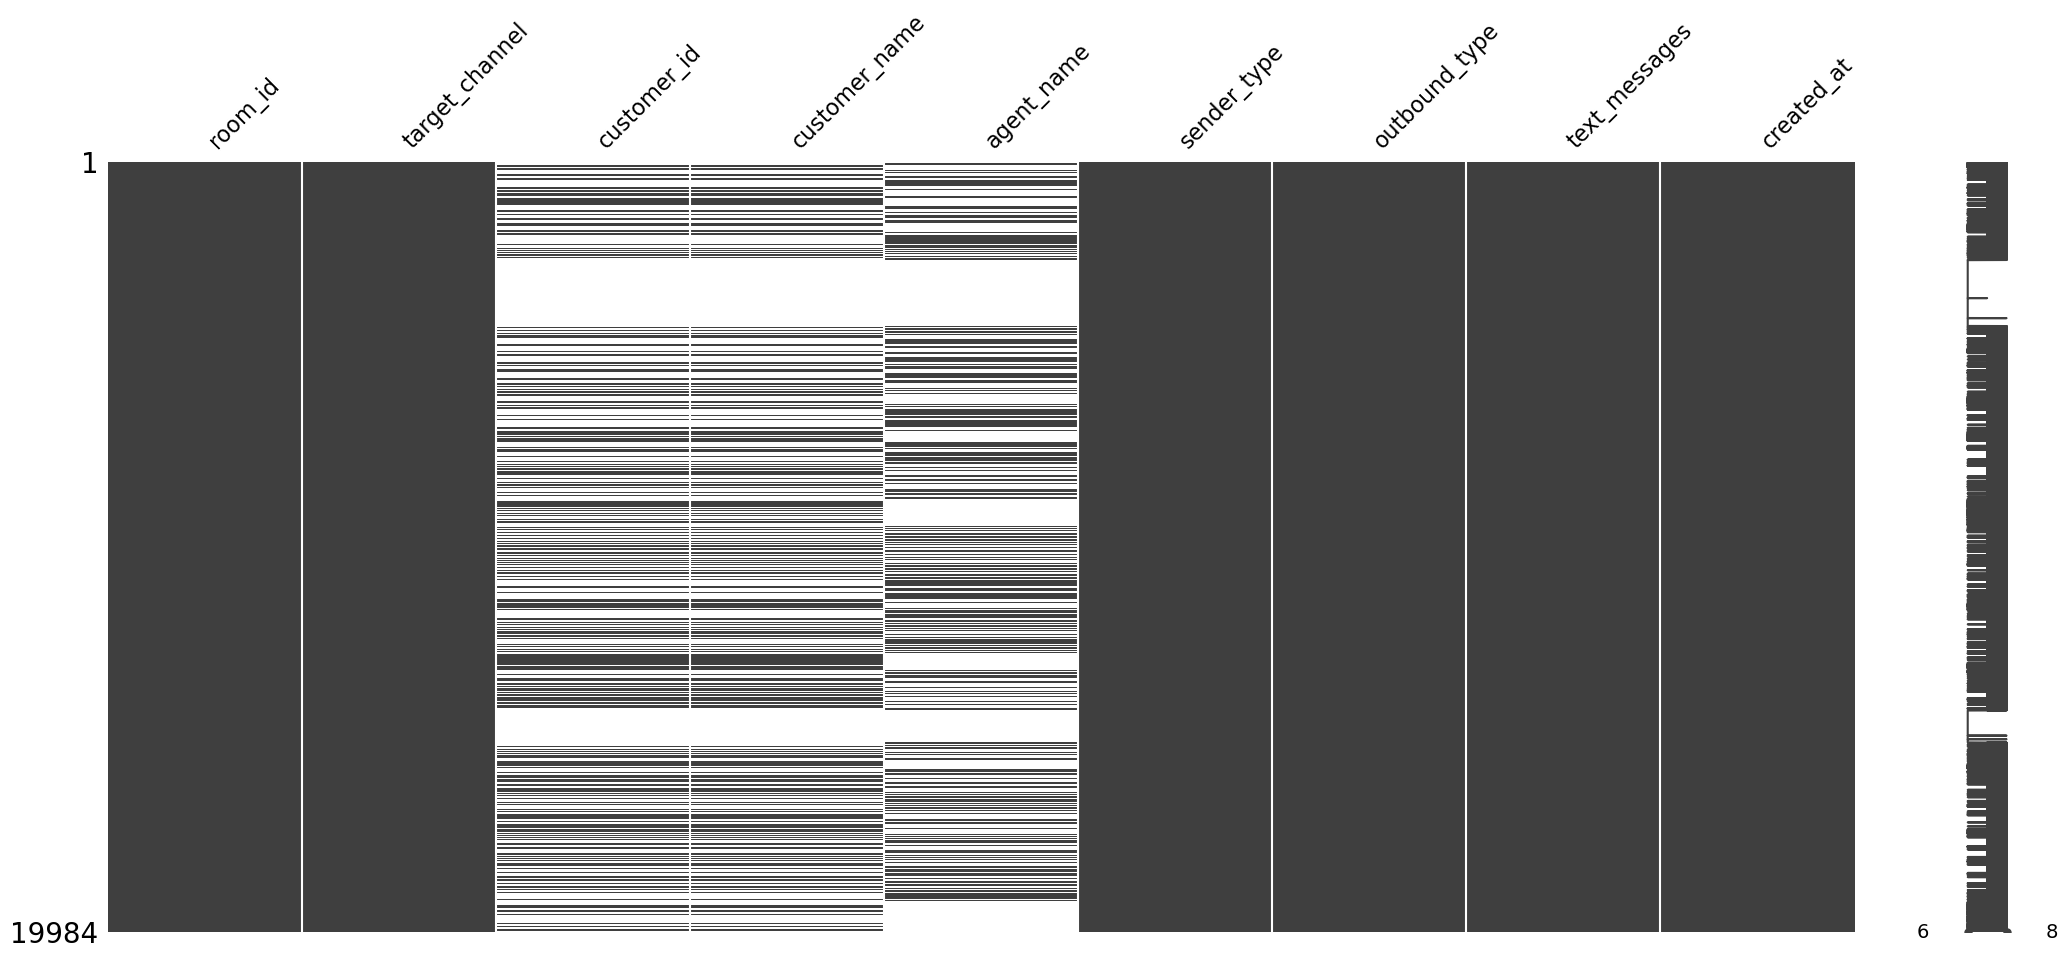

In [839]:
# create missingno matrix
msno.matrix(df_chat)

***MissingNo Matrix*** membantu untuk visualisasi *dataframe* yang memiliki nilai kosong. Pada visualisasi ini, nilai kosong diberi warna putih sednagkan nilai yang tersedia diberi warna abu-abu. Jika diperhatikan lebih lanjut, ada pola dalam nilai kosong *dataframe* tersebut:

1. Beberapa baris memiliki nilai kosong untuk tiga kolom 'customer_id', 'customer_name' dan 'agent_name'.
2. Beberapa baris memiliki nilai kosong untuk dua kolom 'customer_id' dan 'customer_name'.
3. Beberapa baris memiliki nilai kosong untuk satu kolom 'agent_name'.

Oleh karena itu, dilakukan *sampling* untuk pengecekan seperti apa data yang kosong dalam setiap polanya.

In [840]:
# check sampling NaN value customer
df_chat[df_chat['customer_id'].isna()].sample(1)

,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at
10998,b903dc4b-ccba-4910-bc97-a534473a68b7,Whatsapp,NaN,NaN,Bintan,agent,reguler,Oke kak :),2023-11-13 15:43:06.128585+07:00


In [841]:
# check sampling NaN value agent
df_chat[df_chat['agent_name'].isna()].sample(1)

,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at
1233,01022223-a910-4338-89c0-86cc449b2c6c,Whatsapp,+1-544-316-6999,Fikih Firmansyah,NaN,customer,reguler,Saya mau daftar kak,2023-11-06 14:12:47+07:00


In [842]:
# check sampling NaN value agent dan customer
df_chat[(df_chat['customer_id'].isna()) & (df_chat['agent_name'].isna())].sample(1)

,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at
18149,7d964af1-1ff3-46ef-85bf-a4cc7834e8bb,Whatsapp,NaN,NaN,NaN,system,system_info,Halo 👋🏼 saya tim Admission Purwadhika\n\nTerima kasih ya sudah menghubungi Purwadhika Digital Technology School. \n\nMohon menunggu sebentar karena saya akan segera membantu kamu.\n\nSelagi menunggu yuk isi data kamu terlebih dahulu sehingga kami bisa melayani kamu dengan lebih baik 🙏🏼\n\n1. Nama :\n2. Email :\n3. Kamu tertarik program Purwadhika yang mana? :\n,2023-11-17 11:53:24.087916+07:00


***Insight:***
- *Missing value* berada pada kolom 'customer_id', 'customer_name', dan 'agent_name'.
- Percakapan dari calon prospek berarti nilai dari *agent* menjadi *NaN*, dan berlaku sebaliknya.
- Percakapan menggunakan *bot* Mekari Qontak membuat nilai dari calon prospek dan *agent* menjadi *NaN*.
- Nilai yang kosong tidak diberikan perlakuan apapun karena setiap nilai kosong memberikan arti asal pihak yang melakukan percakapan.

### ***Customer Origin***

Purwadhika memiliki tiga kontak utama, yaitu *Website*, *Whatsapp* dan *Instagram*. Ketika calon prospek melakukan kontak melalui *Website*, calon prospek akan diarahkan ke *Whatsapp* dengan *template* pesan seperti berikut:

---
Hai! Kamu akan terhubung dengan Tim Admission Job Connector Bootcamp!
1. Nama:
2. Email:
3. Metode belajar:
4. Program kelas yang ingin diikuti:
5. Tahu Purwadhika pertama kali darimana:
---

- Pesan akan dikategorikan berdasarkan kontak utama yang dimiliki Purwadhika, ditambah dengan kategori 'Blast' untuk pesan yang dikirimkan *system*.

In [843]:
origin = df_chat.copy()
origin = origin.sort_values('created_at', ascending=True)
origin = origin.drop_duplicates(subset='room_id', keep='first')

# membuat kolom baru
origin['customer_origin'] = None

# percakapan dari system ditandai 'Blast'
origin['customer_origin'] = np.where(origin['sender_type']=='system', 'Blast', origin['customer_origin'])

# Mengubah template Bahasa Inggris
origin['text_messages'] = origin['text_messages'].str.replace('Hi! Thank you for contacting Purwadhika', 'Hai! Kamu akan terhubung dengan Tim Admission')

# Template website
origin['customer_origin'] = np.where((origin['sender_type']=='customer') & (origin['text_messages'].str.contains('Hai! Kamu akan terhubung dengan Tim Admission', case=False)), 'Website', origin['customer_origin'])

# Replace value None kolom 'customer_origin' dengan value asli dari 'target_channel'
origin['customer_origin'] = np.where(origin['customer_origin'].isna(), origin['target_channel'], origin['customer_origin'])

# Chat langsung melalui Whatsapp diubah menjadi Direct (tidak menggunakan template)
origin['customer_origin'] = origin['customer_origin'].replace('Whatsapp', 'Direct')

In [844]:
origin = origin[['room_id', 'customer_origin']]
origin['customer_origin'].value_counts()

customer_origin
Blast      2016
Website     500
Direct      328
Name: count, dtype: int64

Terdapat banyak percakapan yang berupa 'Blast' atau dihasilkan *system*. Hal ini sangat mungkin terjadi karena banyaknya kontak yang tersimpan dalam Mekari Qontak sejak tahun 2022 dan tetap menerima pesan *system*, contohnya pengiriman promo dan *event* Purwadhika.

### ***Agent Handler***

- Calon prospek yang melakukan *enquiry* akan dilayani oleh *agent* Tim Pendaftaran Purwadhika. 
- Pada kolom ini, *agent handler* ditentukan berdasarkan nama *agent* yang paling banyak melakukan percakapan dengan calon prospek.

In [845]:
agent_handler = df_chat.copy()

In [846]:
agent_handler = agent_handler[agent_handler['sender_type']=='agent']
agent_handler['agent_handler'] = agent_handler.groupby('room_id')['agent_name'].transform(lambda x: x.value_counts().idxmax())

In [847]:
agent_handler = agent_handler[['room_id', 'agent_handler']]
agent_handler = agent_handler.drop_duplicates()

### ***Products***

- Pada saat pertama kali calon prospek menghubungi Tim Pendaftaran Purwadhika, calon prospek menyatakan produk *bootcamp* Purwadhika yang diminati.
- Ada calon prospek yang berasal dari *Website* sehingga diberikan template untuk memudahkan ekstrak data, namun ada juga yang langsung menghubungi melalui *Whatsapp/Instagram*. Pada kolom ini, informasi produk akan diekstrak dari pesan baik yang sesuai template atau tidak.

#### ***Template***
- Calon prospek mengisi *template* seperti yang tertulis pada bagian **Customer Origin**.
- Produk bootcamp diekstrak menggunakan frasa dari *template* seperti berikut:

Hai! Kamu akan terhubung dengan Tim Admission Job Connector Bootcamp!
1. Nama:
2. Email:
3. Metode belajar: </br>
4. **Program kelas yang ingin diikuti:**
5. Tahu Purwadhika pertama kali darimana:

In [848]:
products_prep = df_chat.copy()

# Mengubah template Bahasa Inggris
products_prep['text_messages'] = products_prep['text_messages'].str.replace('Hi! Thank you for contacting Purwadhika', 'Hai! Kamu akan terhubung dengan Tim Admission')
products_prep['text_messages'] = products_prep['text_messages'].str.replace('Which classes are you interested in joining from the Job Connector International Program?', 'Program kelas yang ingin diikuti')

# Fungsi untuk mengekstrak informasi program kelas dengan regex
def extract_program(text):
    match = re.search(r'Program kelas yang ingin diikuti: (.+?)(?=\n|$)', text)
    if match:
        program = match.group(1).strip()
        # Mengambil teks dari awal hingga titik pertama, jika ada
        return program.split('.')[0]
    return None

products = products_prep.copy()
# Membuat kolom baru 'product' dengan data yang diekstrak
products['products'] = products['text_messages'].apply(extract_program)

***Cleaning Values***
- Membersihkan hasil yang didapat dari ekstrak produk.

In [849]:
products['products'] = products['products'].str.replace('_1', '-')
products['products'] = products['products'].str.replace(' 0', '')
products['products'] = products['products'].str.replace(' 5', '')
products['products'] = products['products'].str.replace(' 6', '')
products['products'] = products['products'].str.replace(':r ', '')
products['products'] = products['products'].str.replace(':  ', '')
products['products'] = products['products'].str.replace(': ', '')

In [850]:
products['products'] = products['products'].replace('Job Connector Bootcamp UI/UX Designer', 'Job Connector Bootcamp UI/UX Design')
products['products'] = products['products'].replace('Full Stack Digital Marketing', 'Job Connector Bootcamp Digital Marketing')
products['products'] = products['products'].replace('Digital Talent Incubator Data analyst', 'Digital Talent Incubator Data Science and Machine Learning')
products['products'] = products['products'].replace('Digital Talent Incubator Data Science & Machine Learning', 'Digital Talent Incubator Data Science and Machine Learning')
products['products'] = products['products'].replace('Job Connector Bootcamp fullstack web development', 'Job Connector Bootcamp Fullstack Web Development')
products['products'] = products['products'].replace('Skill Accelerator Bootcamp UI/UX', 'Skill Accelerator Bootcamp UI/UX Design')
products['products'] = products['products'].replace('Job Connector Bootcamp Full stack Web Development', 'Job Connector Bootcamp Fullstack Web Development')
products['products'] = products['products'].replace('Job Connector Bootcamp - data science & machine learning', 'Job Connector Bootcamp Data Science and Machine Learning')
products['products'] = products['products'].replace('Job Connector Bootcamp Data Science & Machine Learning', 'Job Connector Bootcamp Data Science and Machine Learning')
products['products'] = products['products'].replace('Job Connector Bootcamp Data Science and Machine Learning (Online)', 'Job Connector Bootcamp Data Science and Machine Learning')
products['products'] = products['products'].replace('Job Connector  Bootcamp Fullstack Web Development', 'Job Connector Bootcamp Fullstack Web Development')
products['products'] = products['products'].replace('Jobb Connector Bootcamp Digital Marketing', 'Job Connector Bootcamp Digital Marketing')
products['products'] = products['products'].replace('Data Analytics', 'Skill Accelerator Bootcamp Data Analytics')
products['products'] = products['products'].replace('Skill Accelerator Digital Marketing', 'Skill Accelerator Bootcamp Digital Marketing 360')
products['products'] = products['products'].replace('SEO Specialist', 'Skill Accelerator Bootcamp Search Engine Optimization (SEO)')



In [851]:
# Dataframe products menggunakan template
products = products[['room_id', 'products']]
products = products.dropna()
products = products.drop_duplicates(subset='room_id', keep='last')
products.set_index('room_id', inplace=True)
products.head()

,products
room_id,
06cf18b2-e435-46aa-8264-25bb078dbdfd,Job Connector Bootcamp Fullstack Web Development
551f25d3-236a-40f1-b9f9-7fb09d76e9af,Job Connector Bootcamp Fullstack Web Development
20c7c8f9-4d8b-47b6-bcef-908b3f55846b,Job Connector Bootcamp Data Science and Machine Learning
7eaba296-86c8-41ba-b46b-36180948d3ee,Skill Accelerator Bootcamp Data Analytics
495e74c7-e7cd-4453-9702-b7621b16ae51,Job Connector Bootcamp Fullstack Web Development


#### ***Non-Template***

- Praktis dalam kesehariannya, banyak calon prospek yang menghubungi langsung melalui *Whatsapp* dan tidak menggunakan *template*.
- Contoh: 

*"Kak saya minat pada program bootcamp data science"*

In [852]:
products_no = products_prep.copy()

# Melakukan merge data dengan dataframe products
products_no = products_no[['target_channel', 'room_id', 'sender_type', 'text_messages', 'created_at']]
products_no = products_no.merge(right=products, left_on='room_id', right_on='room_id', how='left')
products_no = products_no[products_no['products'].isna()]

In [853]:
# klasifikasi pernyataan dan pertanyaan
products_no['statement'] = products_no['text_messages'].apply(lambda x: 'question' if '?' in x else 'statement')
products_no['statement'].value_counts()

statement
statement    7092
question     2934
Name: count, dtype: int64

Ciri-ciri percakapan yang ingin ditangkap yaitu:
- Percakapan yang merupakan pernyataan
- Berasal dari calon prospek
- Pesan dari *Whatsapp*

In [854]:
# filter percakapan yang berupa pernyataan, percakapan calon prospek dan berasal dari Whatsapp
products_no = products_no[products_no['statement'] == 'statement']
products_no = products_no[products_no['sender_type'] == 'customer']
products_no = products_no[products_no['target_channel'] == 'Whatsapp']
products_no['text_messages'] = products_no['text_messages'].apply(lambda x : x.lower())

In [855]:
# dataframe products yang tidak terdeteksi melalui template
products_no_na = products_no[(products_no['products'].isna()) | (products_no['products'] == '-')]

***Find Product***

In [856]:
# function find_product
def find_product(text):
    list_product = []
    # produk Digital Talent Incubator
    if 'digital talent incubator' in text or 'dti' in text:
        if 'digital marketing' in text:
            list_product.append('dtidm')
        elif 'data science' in text:
            list_product.append('dtids')
        elif 'software' in text:
            list_product.append('dtise')
        else:
            list_product.append('dti')
    # produk Job Connector & Skill Accelerator Bootcamp
    elif 'data science' in text:
        list_product.append('ds')
    elif 'full stack' in text or 'fullstack' in text or 'web development' in text:
        list_product.append('jcwd')
    elif 'ui/ux' in text:
        list_product.append('ui/ux')
    elif 'visual design' in text:
        list_product.append('jcvd')
    elif 'data analytics' in text:
        list_product.append('sabda')
    elif 'digital marketing 360' in text or '360' in text:
        list_product.append('360')
    elif 'digital marketing' in text:
        list_product.append('dm')
    elif 'skill accelerator' in text or 'ads' in text or 'digital marketing ads' in text:
        list_product.append('ad')
    elif 'search engine optimization' in text or 'seo' in text:
        list_product.append('seo')
    elif 'skill accelerator' in text and 'ui/ux' in text:
        list_product.append('sabui/ux')
    elif 'skill accelerator' in text and 'product management' in text:
        list_product.append('sabpm')
    elif 'product management' in text:
        list_product.append('jcpm')

    return ''.join(list_product) if list_product else ''

In [857]:
# Apply function
products_no_na['search'] = products_no_na['text_messages'].apply(find_product)

**Menggabungkan beberapa produk yang kemungkinan ditanyakan dalam satu *chat room* yang sama**

- Ada kemungkinan calon prospek menyatakan minat terhadap beberapa produk, sehingga informasi yang ingin didapatkan akan mencakup semua yang disebutkan calon prospek.

In [858]:
products_no_na = products_no_na.sort_values(by='room_id')[['room_id','search']]

In [859]:
result_dict = {}
# Loop through each row in the DataFrame
for index, row in products_no_na.iterrows():
    room_id = row['room_id']
    search = row['search']
    if room_id in result_dict:
        if search not in result_dict[room_id]:
            result_dict[room_id] += search
    else:
        result_dict[room_id] = search
# Convert the dictionary to a DataFrame
result = pd.DataFrame(list(result_dict.items()), columns=['room_id_no', 'search'])

***Cleaning Values***

- Banyaknya teks yang tidak beraturan sehingga akan dibersihkan terlebih dahulu untuk diproses lebih lanjut.

In [860]:
# Function untuk mengganti kata kunci
def replace_multiple(text, replace_dict):
    for key, value in replace_dict.items():
        text = text.replace(key, value)
    return text

In [861]:
dict_cleaning_search = {
    'seodm' : 'seo, jcdm',
    'jcwdad' : 'jcwd, ad',
    '360ad' : '360, ad',
    'dsjcwd' : 'jcds, jcwd',
    'dsdm' : 'jcds, jcdm',
    'jcwdds' : 'jcwd, jcds',
    '360ad' : '360, ad',
    'dtiad' : 'dti, ad',
    'dmdti' : 'dtidm',
    'dsdti' : 'dtids',
    'addm' : 'ad',
    'dmad' : 'ad',
    'adds' : 'ad, jcds',
    'dsad' : 'jcds, ad',
    'addti' : 'ad, dti',
    'seoad' : 'seo, ad',
    'sabdaad' : 'sabda, ad',
    'adsabda' : 'sabda, ad',
    'dm360' : '360',
    'adui/ux' : 'ad, ui/ux',
    'dmds' : 'jcds, jcdm',
    'dmseo' : 'seo, jcdm',
    'adjcwd' : 'jcwd, ad'
}

result['search'] = result['search'].apply(replace_multiple, replace_dict = dict_cleaning_search)

**Penyeragaman *products***

- Setelah produk dipisahkan dan diseragamkan, setiap nilainya diubah dengan nama produk resmi yang dimiliki Purwadhika.

In [862]:
dict_correct_product = {
    'dtidm' : 'Digital Talent Incubator Digital Marketing',
    'dtids' : 'Digital Talent Incubator Data Science and Machine Learning',
    'dtise' : 'Digital Talent Incubator Software Engineering',
    '360' : 'Skill Accelerator Bootcamp Digital Marketing 360',
    'sabda' : 'Skill Accelerator Bootcamp Data Analytics',
    'sabpm' : 'Skill Accelerator Bootcamp Product Management',
    'jcvd' : 'Job Connector Bootcamp Visual Design',
    'jcwd' : 'Job Connector Bootcamp Fullstack Web Development',
    'jcpm' : 'Job Connector Bootcamp Product Management',
    'jcds' : 'Job Connector Bootcamp Data Science and Machine Learning',
    'ui/ux' : 'Job Connector Bootcamp UI/UX Design',
    'jcdm' : 'Job Connector Bootcamp Digital Marketing',
    'seo' : 'Skill Accelerator Bootcamp Search Engine Optimization (SEO)',
    'dti' : 'Digital Talent Incubator',
    'ds' : 'Job Connector Bootcamp Data Science and Machine Learning',
    'ad' : 'Skill Accelerator Bootcamp Digital Marketing Ads',
    'dm' : 'Job Connector Bootcamp Digital Marketing'
}

In [863]:
# Apply function
result['search'] = result['search'].apply(replace_multiple, replace_dict=dict_correct_product)

In [864]:
result = result[result['search'] != '']
result.set_index('room_id_no', inplace=True)
result.head()

,search
room_id_no,
05322c19-9ed5-4e0b-b2aa-3ffde4efc6ec,Job Connector Bootcamp Data Science and Machine Learning
0718d5e1-cb2a-4832-b35d-db0ce60c1070,Job Connector Bootcamp Fullstack Web Development
0ab27537-59d4-4479-9494-587dbe59ace5,Job Connector Bootcamp Data Science and Machine Learning
0c482266-fa6d-404e-bde5-9709d297acf1,Digital Talent Incubator
0f3ff377-7a7b-4af4-ada0-f85ad1b6c21c,Digital Talent Incubator


**Menggabungkan *dataframe* dengan *products (by template)***

In [865]:
final_products = pd.concat(objs= [products, result], axis = 1, join = 'outer')

In [866]:
# final_products['room_id'] = np.where(final_products['room_id'].isna(), final_products['room_id_no'], final_products['room_id'])
final_products['products'] = np.where(final_products['products'].isna(), final_products['search'], final_products['products'])
final_products.drop(columns=['search'], inplace = True)
final_products['products'] = final_products['products'].str.replace(' 4', '')

In [867]:
final_products.reset_index(inplace=True)
final_products.rename(columns={'index' : 'room_id'}, inplace=True)
final_products.head()

,room_id,products
0,06cf18b2-e435-46aa-8264-25bb078dbdfd,Job Connector Bootcamp Fullstack Web Development
1,551f25d3-236a-40f1-b9f9-7fb09d76e9af,Job Connector Bootcamp Fullstack Web Development
2,20c7c8f9-4d8b-47b6-bcef-908b3f55846b,Job Connector Bootcamp Data Science and Machine Learning
3,7eaba296-86c8-41ba-b46b-36180948d3ee,Skill Accelerator Bootcamp Data Analytics
4,495e74c7-e7cd-4453-9702-b7621b16ae51,Job Connector Bootcamp Fullstack Web Development


### ***Branch***

- Pada saat pertama kali calon prospek menghubungi Tim Pendaftaran Purwadhika, calon prospek menyatakan cabang *bootcamp* Purwadhika yang diminati.
- Ada calon prospek yang berasal dari *Website* sehingga diberikan template untuk memudahkan ekstrak data, namun ada juga yang langsung menghubungi melalui *Whatsapp/Instagram*. Pada kolom ini, informasi produk akan diekstrak dari pesan baik yang sesuai template atau tidak.

#### ***Template***

- Calon prospek mengisi *template* seperti yang tertulis pada bagian **Customer Origin**.
- Cabang *bootcamp* diekstrak menggunakan frasa dari *template* seperti berikut:

Hai! Kamu akan terhubung dengan Tim *Admission Job Connector Bootcamp*!
1. Nama:
2. Email: </br>
3. **Metode belajar:**
4. Program kelas yang ingin diikuti:
5. Tahu Purwadhika pertama kali darimana:

In [868]:
branch_prep = df_chat.copy()
branch_prep = branch_prep[['room_id', 'target_channel', 'text_messages', 'created_at', 'sender_type']]

In [869]:
# klasifikasi pernyataan dan pertanyaan
branch_prep['statement'] = branch_prep['text_messages'].apply(lambda x: 'question' if '?' in x else 'statement')
branch_prep['statement'].value_counts()

statement
statement    14384
question      5600
Name: count, dtype: int64

Ciri-ciri percakapan yang ingin ditangkap yaitu:
- Percakapan yang merupakan pernyataan
- Berasal dari calon prospek
- Pesan dari *Whatsapp*

In [870]:
# pilih hanya percakapan customer, pernyataan dan Whatsapp
branch_prep = branch_prep[branch_prep['sender_type'] == 'customer']
branch_prep = branch_prep[branch_prep['statement'] == 'statement']
branch_prep = branch_prep[branch_prep['target_channel'] == 'Whatsapp']

branch_prep = branch_prep[['room_id', 'text_messages', 'created_at']]

In [871]:
branch_template = branch_prep.copy()

# Mengubah template Bahasa Inggris
branch_template['text_messages'] = branch_template['text_messages'].str.replace('Hi! Thank you for contacting Purwadhika', 'Hai! Kamu akan terhubung dengan Tim Admission')
branch_template['text_messages'] = branch_template['text_messages'].str.replace('Study method:', 'Metode belajar:')

branch_template = branch_template[branch_template['text_messages'].str.contains('Hai! Kamu akan terhubung dengan Tim Admission', case=False)]

# Fungsi untuk mengekstrak informasi program kelas dengan regex
def extract_branch(text):
    match = re.search(r'Metode belajar: (.+?)(?=\n|$)', text)
    if match:
        branch_template = match.group(1).strip()
        # Mengambil teks dari awal hingga titik pertama, jika ada
        return branch_template.lower().split('.')[0]
    return None

# Fungsi untuk menambah spasi sebelum dan sesudah tanda baca
def add_spaces_around_punctuation(text):
    # Pattern regex
    pattern = r'([/])'
    # Menambah spasi sebelum dan sesudah tanda baca '/'
    spaced_text = re.sub(pattern, r' \1 ', text)
    # Menghilangkan spasi lebih dari satu, spasi setelah dan sebelum kata
    spaced_text = re.sub(r'\s+', ' ', spaced_text)
    spaced_text = spaced_text.strip()
    return spaced_text

# Membuat kolom baru 'branch' dengan data yang diekstrak
branch_template['branch'] = branch_template['text_messages'].apply(extract_branch)
# Menghilangkan values digit
branch_template['branch'] = branch_template['branch'].replace(to_replace=r' \d+', value='', regex=True)
# Apply function add_spaces_around_punctuation
branch_template['branch'] = branch_template['branch'].apply(lambda x : add_spaces_around_punctuation(x) if pd.notna(x) else x)

In [872]:
branch_template['branch'] = np.where(branch_template['branch'] == '-', None, branch_template['branch'])
branch_template['branch'].value_counts(dropna=False)

branch
online                284
on campus jkt          90
None                   37
on campus bandung      35
on campus bsd          25
on campus batam        24
on campus jogja        23
on campus surabaya     18
- online                1
on campus               1
Name: count, dtype: int64

In [873]:
branch_template = branch_template[['room_id', 'branch']]

In [874]:
# check duplikasi data
branch_template.duplicated().sum()

12

In [875]:
# drop duplikasi
branch_template.drop_duplicates(subset='room_id', inplace=True)

In [876]:
# Melakukan merge data dengan dataframe branch_template
branch_prep = branch_prep.merge(right = branch_template, left_on='room_id', right_on='room_id', how='left')

branch_no = branch_prep.copy()
branch_no = branch_no[branch_no['branch'].isna()]

#### ***Non-template***

- Praktis dalam kesehariannya, banyak calon prospek yang menghubungi langsung melalui *Whatsapp* dan tidak menggunakan *template*.
- Contoh: 

*"Kak saya mau di BSD"*

In [877]:
keywords_list = ['jakarta', 'jkt', 'bsd', 'surabaya', 'sby', 'sub', 'batam', 'dti', 'bandung', 'bdg', 'yogya', 'jogja', 
                 'jogjakarta', 'online', 'off', 'offline', 'campus', 'kampus', 'digital talent incubator']

# Function mencari dan menggabungkan kata kunci
def find_keywords(text, keywords):
    words = text.split()
    match = []
    for word in words:
        if word in keywords:
            match.append(word)
    return ', '.join(match)

In [878]:
# Apply function
branch_no['search'] = branch_no['text_messages'].apply(lambda x: find_keywords(x, keywords_list))

**Pesan dengan kata kunci**

In [879]:
# filter percakapan yang memiliki kata kunci
branch_key = branch_no[branch_no['search'].str.strip().str.len() > 0]

In [880]:
# dictionary untuk menyeragamkan kata kunci
dict_search = {
    'jakarta' : 'jkt',
    'surabaya' : 'sby',
    'bandung' : 'bdg',
    'digital talent incubator' : 'batam',
    'dti' : 'batam',
    'campus' : 'oncampus',
    'kampus' : 'oncampus',
    'off' : 'oncampus',
    'yogya' : 'jogja',
    'sub' : 'sby',
    'offline' : 'oncampus',
    'jogjakarta' : 'jogja'
}

# function untuk koreksi kata kunci
def correct_search(text):
    words = text.split(', ')

    for j in range(len(words)):
        if words[j] in dict_search:
            words[j] = dict_search[words[j]]

    expanded_text = ', '.join(words)
    return expanded_text

In [881]:
# Apply function
branch_key['search'] = branch_key['search'].apply(correct_search)

**Menghapus duplikasi kata kunci**
- Ada kemungkinan beberapa kata kunci yang disebutkan berulang, oleh karena itu duplikasi akan dihapus.

In [882]:
# function menghapus duplikasi kata kunci
def delete_duplicates(text):
    words = text.split(', ')
    seen = set()
    unique_words = []

    for word in words:
        if word not in seen:
            unique_words.append(word)
            seen.add(word)

    return ', '.join(unique_words)

In [883]:
# Apply function
branch_key['search'] = branch_key['search'].apply(delete_duplicates)

**Menggabungkan kata 'on campus' dan cabang**

- Banyak teks yang tidak beraturan seperti penyebutan nama cabang saja, sehingga nama cabang akan dilengkapi dengan 'on campus'.

In [884]:
def correct_oncampus(text):
    words = text.split()
    list_branch = ['jkt', 'bdg', 'sby', 'batam', 'bsd', 'jogja']
    list_oncampus = ['on campus bsd', 'on campus jkt', 'on campus sby', 'on campus jogja', 'on campus batam', 'on campus bdg', 'online']
    corrected_words = []
    prep_corrected_words = []
    final_corrected_words = []
    
    # Menyeragamkan kata kunci 'on campus' dan 'online'
    for word in words:
        if word == 'oncampus,':
            corrected_words.append('on campus,')
        elif word == 'oncampus':
            corrected_words.append('on campus')
        elif word == 'online,':
            corrected_words.append('online,')
        elif word in list_branch:
            corrected_words.append('on campus ' + word)
        elif word[:-1] in list_branch and word[-1] == ',':
            corrected_words.append('on campus ' + word[:-1] + ',')
        else:
            corrected_words.append(word)
    
    # Menghapus duplikasi kata 'on campus'
    i = 0
    while i < len(corrected_words):
        if corrected_words[i] == 'on campus':
            if i + 1 < len(corrected_words) and corrected_words[i + 1].startswith('on campus'):
                prep_corrected_words.append(corrected_words[i + 1])
                i += 1
            else:
                prep_corrected_words.append(corrected_words[i])
        else:
            prep_corrected_words.append(corrected_words[i])
        i += 1
    
    # koreksi list search, kecuali search yang hanya memiliki value 'online' dan 'on campus'
    onoff_check = ' '.join(prep_corrected_words)
    match = re.search(r'online, on campus', onoff_check)
    match1 = re.search(r'on campus, online', onoff_check)
    if match:
        final_corrected_words.append(match.group())
    elif match1:
        final_corrected_words.append(match1.group())
    elif len(prep_corrected_words) > 1:
        for k in range(len(prep_corrected_words)):
            for oncampus in list_oncampus:
                if prep_corrected_words[k].endswith(','):
                    prep_corrected_words[k] = prep_corrected_words[k][:-1]
                    if prep_corrected_words[k] == oncampus:
                        final_corrected_words.append(prep_corrected_words[k])
                else:
                    if prep_corrected_words[k] == oncampus:
                        final_corrected_words.append(prep_corrected_words[k])
    else:
        final_corrected_words.append(' '.join(prep_corrected_words))
    return ', '.join(final_corrected_words)

In [885]:
# Apply function
branch_key['search'] = branch_key['search'].apply(correct_oncampus)

**Menggabungkan *dataframe* dengan *branch (by template)***

In [886]:
branch_new = branch_prep.merge(right=branch_key[['room_id', 'search']], left_on='room_id', right_on='room_id', how='left')

In [887]:
# replace value NaN pada kolom 'branch' dengan kolom 'search' (non-template)
branch_new['branch'] = np.where(branch_new['branch'].isna(), branch_new['search'], branch_new['branch'])

In [888]:
branch_new['branch'].value_counts()

branch
online                            1861
on campus jkt                      832
on campus bandung                  275
on campus                          270
on campus bsd                      270
on campus batam                    241
on campus bdg                      147
on campus sby                      144
on campus jogja                    140
on campus surabaya                  89
online, on campus                   49
on campus, online                   22
on campus bsd, on campus jkt        17
- online                             9
on campus jogja, on campus sby       7
on campus jkt, on campus sby         5
Name: count, dtype: int64

In [889]:
# dictionary untuk menyeragamkan cabang
dict_branch = {
    'on campus jkt' : 'On Campus Jakarta',
    'on campus jakarta' : 'On Campus Jakarta',
    'kampus jkt' : 'On Campus Jakarta',
    'on campus bdg' : 'On Campus Bandung',
    'on campus bandung' : 'On Campus Bandung',
    'on campus bsd ' : 'On Campus BSD',
    'on campus bsd' : 'On Campus BSD',
    'bsd' : 'On Campus BSD',
    'on campus jogja' : 'On Campus Jogja',
    'on campus batam' : 'On Campus Batam',
    'on campus  batam' : 'On Campus Batam',
    'on campus sby' : 'On Campus Surabaya',
    'on campus surabaya' : 'On Campus Surabaya',
    'onlinee' : 'Online',
    'online' : 'Online',
    ' / ' : ', ',
    '/' : ',',
    '- ' : '',
    'metode ' : '',
    ' atau' : ',',
    '&' : ',',
    'offline' : 'On Campus',
    'on campus' : 'On Campus'
}

In [890]:
# Apply function replace_multiple untuk menyeragamkan cabang
branch_new['branch'] = branch_new['branch'].apply(lambda x: replace_multiple(x, dict_branch) if pd.notna(x) else x)

In [891]:
branch_new = branch_new[['room_id', 'branch']]

In [892]:
# cek duplikasi data
branch_new.duplicated().sum()

4950

In [893]:
# drop duplikasi data
branch_new.drop_duplicates(subset=['room_id', 'branch'], keep='last', inplace=True)

### ***Room Created***
Pada kolom ini, setiap *chat room* akan diberi tanggal pertama kali percakapan dimulai.

In [894]:
room_created = df_chat.copy()
room_created = room_created.groupby('room_id')[['created_at']].first().reset_index().rename(columns={'created_at':'room_created'})
room_created

,room_id,room_created
0,0003172b-353d-4597-baae-589c294d2058,2023-11-07 13:31:41+07:00
1,002a9e9b-fd59-4682-8148-8b8aa333647c,2023-11-07 13:31:48+07:00
2,004004ff-4da7-4c58-ab9b-e850e6022a85,2023-11-07 13:31:39+07:00
3,004aa5ae-102a-45c6-b7ea-ad4fc0ad86ea,2023-11-07 13:31:50+07:00
4,006d10a1-8d51-4ed0-bcef-672e01157fea,2023-11-07 13:32:39+07:00
...,...,...
2839,ffae6cb4-0ab9-4613-8a52-3cf27dc31e76,2023-11-07 13:31:51+07:00
2840,ffbc3c82-4c75-437e-aee2-f113e74b31e0,2023-11-18 05:47:32+07:00
2841,ffcc12ee-16ef-42e0-accd-076acab0a47a,2023-11-07 13:31:52+07:00
2842,ffdbff9e-714a-40bb-a575-0fb576260af6,2023-11-15 14:12:55+07:00


### ***Room Status***

Pada kolom ini, *chat room* akan ditandai berdasarkan percakapan yang pernah dibalas *agent*
- Pernah ada *agent* yang membalas --> *Assign*
- Tidak pernah/belum ada *agent* yang membalas --> *Unassign*

In [895]:
assign = df_chat.copy()

# filter percakapan yang melibatkan agent, value nya adalah Assign
assign = assign[assign['sender_type']=='agent']
assign['room_status'] = 'Assign'

In [896]:
# Merge dengan df_chat
room_status = df_chat.merge(assign, on='room_id', how='left')
room_status['room_status'] = room_status['room_status'].fillna('Unassign')

In [897]:
room_status = room_status[['room_id', 'room_status']]
# drop duplikasi, hanya mengambil unique values
room_status = room_status.drop_duplicates()
room_status['room_status'].value_counts()

room_status
Unassign    2075
Assign       769
Name: count, dtype: int64

### **Waktu Pembayaran**

Proses *enquiry* sampai transaksi semuanya dilakukan melalui *Whatsapp*. Ketika calon prospek mengirimkan bukti transfer, *agent* akan menawarkan *merchandise* jaket untuk pelanggan. Pada kolom ini akan ditentukan:
- Kapan waktu *agent* menawarkan jaket
- *agent* membahas Tim Validasi dan tunggu konfirmasi

In [898]:
payment_time = df_chat.copy()

In [899]:
payment_time['text_messages'] = payment_time['text_messages'].fillna('')

In [900]:
# Menampilkan waktu pembayaran, ciri-cirinya agent menawarkan jaket ke calon prospek
payment_time['payment_time'] = payment_time.groupby('room_id')['created_at'].transform(lambda x: x[((payment_time.loc[x.index, 'text_messages'].str.contains('jaket|jacket',case=False)) & 
                                                                                                    ((payment_time.loc[x.index,'text_messages'].str.contains('size|ukuran|tim validasi|tunggu konfirmasi',case=False))) & 
                                                                                                    (payment_time.loc[x.index,'sender_type'] == 'agent'))].max())
payment_time['payment_time'] = payment_time['payment_time'].astype('datetime64[ns, Asia/Jakarta]')

In [901]:
payment_time = payment_time[payment_time['payment_time'].notna()][['room_id', 'payment_time']]
payment_time = payment_time.drop_duplicates()

In [902]:
list_paid = payment_time['room_id'].tolist()

### **Status Transaksi**

- Calon prospek yang melakukan pendaftaran akan menyelesaikan transaksi. Kolom ini digunakan untuk menandai calon prospek yang sudah berhasil melakukan transaksi.

In [903]:
deal_status = df_chat.copy()
deal_status = deal_status[['room_id']].drop_duplicates()

In [904]:
# Default ubah jadi none
deal_status['deal_status'] = None

# pisahkan data yang sudah menggunakan link invoice
# deal_status = deal_status[(deal_status['given_link_time'].notna())]
deal_status['deal_status'] = np.where((deal_status['room_id'].isin(list_paid)), 'Deal', deal_status['deal_status']) # Deal

# buat status yang tidak deal
deal_status['deal_status'] = np.where(deal_status['deal_status'].isna(), 'Not Deal', deal_status['deal_status'])

In [905]:
deal_status = deal_status[['room_id', 'deal_status']]
deal_status = deal_status.drop_duplicates()

In [906]:
len(deal_status)

2844

In [907]:
deal_status['deal_status'].value_counts()

deal_status
Not Deal    2809
Deal          35
Name: count, dtype: int64

### **Pengirim Pesan Terakhir**

Percakapan antara calon prospek dengan agent tentu harapannya Identifikasi pengirim pesan terakhir dalam suatu *chat room*.

In [908]:
# Daftar kata dan frasa yang ingin difilter
hsm_1 = 'Terkait pendaftaran program kami di Purwadhika, apakah kamu masih tertarik untuk melanjutkannya?' 
hsm_2 = 'Halo, untuk mengaktifkan percakapan ini kembali, mohon balas pesan ini ya'
hsm_3 = 'boleh di bantu utk resend chat nya kembali kak'
hsm_4 = 'Halo 👋🏼 saya Icha tim Admission Purwadhika\n\nTerima kasih ya sudah menghubungi Purwadhika Digital Technology School.'

hsm = [hsm_1, hsm_2, hsm_3, hsm_4]
# Gabungkan kata-kata dan frasa dalam list menjadi satu string dengan pemisah '|'

hsm_pattern = '|'.join([f'({word})' for word in hsm])

hsm_pattern

'(Terkait pendaftaran program kami di Purwadhika, apakah kamu masih tertarik untuk melanjutkannya?)|(Halo, untuk mengaktifkan percakapan ini kembali, mohon balas pesan ini ya)|(boleh di bantu utk resend chat nya kembali kak)|(Halo 👋🏼 saya Icha tim Admission Purwadhika\n\nTerima kasih ya sudah menghubungi Purwadhika Digital Technology School.)'

**Membuat kolom *last sender***

In [909]:
last_chat = df_chat.copy()
last_chat['text_messages'] = last_chat['text_messages'].fillna('')
last_chat = last_chat[(last_chat['sender_type']=='customer') | (last_chat['sender_type']=='agent') | ((last_chat['sender_type']=='system') & (last_chat['text_messages'].str.contains(hsm_pattern, case=False)))]

last_chat = last_chat.sort_values(by=['room_id', 'created_at'])
last_chat['last_sender'] = last_chat.groupby('room_id')['sender_type'].transform('last')
last_chat['last_messages_time'] = last_chat.groupby('room_id')['created_at'].transform('last')
last_chat['last_sender'].value_counts()

C:\Users\hp\AppData\Local\Temp\ipykernel_9032\448690319.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  last_chat = last_chat[(last_chat['sender_type']=='customer') | (last_chat['sender_type']=='agent') | ((last_chat['sender_type']=='system') & (last_chat['text_messages'].str.contains(hsm_pattern, case=False)))]


last_sender
agent       10293
customer     4751
system         63
Name: count, dtype: int64

In [910]:
last_chat = last_chat.sort_values('created_at', ascending=True)
last_chat = last_chat[['room_id', 'text_messages', 'last_sender', 'last_messages_time']]
last_chat = last_chat.rename(columns={'text_messages': 'last_messages'})
last_chat = last_chat.drop_duplicates(subset='room_id', keep='last')

In [911]:
last_chat['last_sender'].value_counts()

last_sender
agent       606
customer    326
system       19
Name: count, dtype: int64

### ***Lost Customer***

Kondisi *lost customer* antara lain:
- ⁠Percakapan sudah di *assign* ke *agent*
- Status transaksi belum *deal*
- Harus menyatakan produk atau cabang yang diminati
- Pengirim pesan terakhir yaitu *system/agent*
- ⁠⁠Pesan terakhir sudah lewat 2 hari dari pesan terakhir *system/agent*

In [912]:
lost_customer = df_chat.copy()
max_time = lost_customer['created_at'].max() # --> max time dataframe (normally means today)

# Mendefinisikan room yang deals
deals = deal_status[deal_status['deal_status']=='Deal']

# Mendefinisikan last sender dan durasi 2 hari
last_time = last_chat.copy()
last_time['duration'] = max_time - last_time["last_messages_time"]
last_time = last_time[((last_time['last_sender']=='agent')|(last_time['last_sender']=='system'))&(last_time['duration']>'1 days')] # --> Mencari semua last sender yang agent/system dan lebih dari 1 hari

lost_customer = lost_customer[lost_customer['room_id'].isin(assign['room_id'].to_list())] # --> Semua room yang sudah assign
lost_customer = lost_customer[~(lost_customer['room_id'].isin(deals['room_id'].to_list()))] # --> Selain room yang deals
lost_customer = lost_customer[lost_customer['room_id'].isin(branch_new['room_id'].to_list())] # --> Semua room yang mempunyai branch
lost_customer = lost_customer[lost_customer['room_id'].isin(final_products['room_id'].to_list())] # --> Semua room yang mempunyai products
lost_customer = lost_customer[lost_customer['room_id'].isin(last_time['room_id'].to_list())] # --> Semua room yang sendernya system/agent dan durasi setelah last chat lebih dari 1 hari

In [913]:
lost_customer["lost_customer"] = "Customer Loss"
lost_customer["text_messages"] = lost_customer["text_messages"].fillna("")
lost_customer = lost_customer[(lost_customer['sender_type']=="customer") | (lost_customer['sender_type']=="agent") | ((lost_customer['sender_type']=="system") & (lost_customer['text_messages'].str.contains(hsm_pattern, case=False)))]
lost_customer = lost_customer[['room_id', "lost_customer", "created_at"]]
lost_customer = lost_customer.drop_duplicates(subset='room_id', keep="last")
lost_customer['created_at'] = lost_customer['created_at'] + pd.Timedelta(days=1)
lost_customer = lost_customer.rename(columns={'created_at': 'loss_time'})
lost_customer['room_id'].nunique()

C:\Users\hp\AppData\Local\Temp\ipykernel_9032\3099818134.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lost_customer = lost_customer[(lost_customer['sender_type']=="customer") | (lost_customer['sender_type']=="agent") | ((lost_customer['sender_type']=="system") & (lost_customer['text_messages'].str.contains(hsm_pattern, case=False)))]


377

In [914]:
lost_customer.tail()

,room_id,lost_customer,loss_time
19055,0397723d-32f1-480f-ac50-99e224e0c5ce,Customer Loss,2023-11-18 17:00:48.066526+07:00
19057,d0ff5fed-e1b9-414b-a4d1-400d9b25e8cb,Customer Loss,2023-11-18 17:02:11.787485+07:00
19088,cc3d1e39-42fa-48a1-811d-dfc06e2828af,Customer Loss,2023-11-18 17:21:20.403890+07:00
19103,c1f421bc-08a4-4066-87df-454bb29dcab2,Customer Loss,2023-11-18 17:28:17.936268+07:00
19121,5bd866d2-f4c6-4c4e-bddc-0e976322147d,Customer Loss,2023-11-18 17:34:05.448880+07:00


### **Klasifikasi calon prospek**

### **Prospek Hangat**

Definisi: percakapan yang memiliki kata-kata atau makna seperti berikut:

- Pengisian identitas diri
- Agent melakukan *follow up*
- Customer diskusi dulu dengan orang tua
- apakah berminat utk di bantu proses pendaftarannya?
- Customer pikir dulu

In [915]:
# copy raw dataframe
lead = df_chat.copy()

In [916]:
# drop text message NaN & lower text
lead.dropna(subset=['text_messages'], inplace=True)
lead['text_messages'] = lead['text_messages'].apply(lambda x : x.lower())

In [917]:
customer_status = lead.copy()

#### **Mencari kata kunci berdasarkan warm lead Admission**

In [918]:
# kata kunci warm lead
list_warm = ['no ktp:', 'follow up', 'followup', 'diskusi', 'discus', 'pikir', 'fikir', 'daftar']

# list kata kunci yang perlu ditake out dari warm lead = 'diskusi'
list_refine_diskusi = ['partnership', 'group', 'grup', 'belum', 'belom', 'tugas', 'bukan', 'mentor', 'guru', 'trainer', 'program', 'refund', 'kelompok', 'mohon', 'sharing',
                       'kerjasama', 'kerja sama', 'agency', 'form', 'bantu', 'lama', 'sesi', 'proposal', 'admission', 'operator', 'lanjut', 'pengajar', 'materi', 'to be', 'sempet',
                       'brain', 'work', 'penyediaan', 'open', 'minus', 'coding', 'teman', 'temen', 'forum', 'pengen', 'fasilitas', 'kadang', 'kurang bisa', 'lebih fleksibel',
                       'siapa', 'agar', 'praktek']

# list kata kunci verifikasi dari message after warm lead = 'pikir'
list_reply_pikir = ['promo', 'baik', 'oke', 'terima kasih', 'makasih', 'makasi', 'sama', 'thanks', 'trmksh', 'boleh', 'mohon maaf']

# list kata kunci verifikasi dari message warm lead ='pikir'
list_advanced_pikir = ['dulu', 'dlu', 'dl', 'nanti', 'lagi', 'lg', 'duluu']

# list kata kunci yang perlu ditake out dari warm lead = 'pikir'
list_refine_pikir = ['promosi', 'pikiran', 'berpikir', 'fikirim', 'cerdas', 'hiring', 'janji', 'sayang', 'mahal', 'les']

# list kata kunci verifikasi dari message after warm lead = 'daftar'
list_advanced_daftar = ['bantu', 'siap', 'mau', 'tolong', 'buka', 'oke', 'lanjut', 'kapan', 'gimana', 'gmn']

# list kata kunci yang perlu ditake out dari warm lead = 'daftar'
list_refine_daftar = ['membantu', 'biaya', 'motor', 'misal', 'mentor', 'kecewa', 'bukan']

In [919]:
# function menambah kolom message setelah
def shift_group_after(group):
    group['message_after'] = group['text_messages'].shift(periods=-1)
    return group

customer_status = customer_status.groupby('room_id').apply(shift_group_after).reset_index(drop=True).sort_values('created_at')
customer_status['message_after'].fillna('', inplace = True)

customer_status.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_9032\72902905.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  customer_status = customer_status.groupby('room_id').apply(shift_group_after).reset_index(drop=True).sort_values('created_at')


,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at,message_after
19380,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"hi👋 \ningin berdiskusi dengan tim admission terkait program kami? mohon menunggu sebentar, tim admission kami akan segera pada jam operasional kami 😁 \nselagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. nama : \n2. email : \n3. kamu tertarik program purwadhika yang mana? : \n4. informasi yang ingin diketahui : \n5. tahu purwadhika pertama kali darimana? :",2023-11-06 07:05:54.755785+07:00,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/pfzs5lhu"
19381,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/pfzs5lhu",2023-11-06 07:05:55.144000+07:00,conversation has been resolved by <b>bot</b>
19382,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,conversation has been resolved by <b>bot</b>,2023-11-06 07:05:55.259056+07:00,survey score has been sent to <b>anisya desy</b>
19383,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,survey score has been sent to <b>anisya desy</b>,2023-11-06 07:05:55.432142+07:00,
2442,1fd4903b-51bd-4ed0-b0d7-4fa783077143,Whatsapp,NaN,NaN,NaN,system,system_info,"hi👋 \ningin berdiskusi dengan tim admission terkait program kami? mohon menunggu sebentar, tim admission kami akan segera pada jam operasional kami 😁 \nselagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. nama : \n2. email : \n3. kamu tertarik program purwadhika yang mana? : \n4. informasi yang ingin diketahui : \n5. tahu purwadhika pertama kali darimana? :",2023-11-06 07:54:46.251957+07:00,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/faxrmhqr"


In [920]:
def is_warm(text, list_warm):
    for word in list_warm:
        if word in text:
            if word == 'diskusi' or word == 'discus' or word == 'konsultasi':   # jika ada kata diskusi, dicek kembali kata dari pesannya
                for noise in list_refine_diskusi:
                    if noise in text:
                        return 'no lead'                   # jika terdapat noise dalam pesan diskusi, ditandai 'no lead'
                return 'warm'
            elif word == 'pikir' or word == 'fikir':    # jika ada kata pikir, dicek kembali kata dari pesannya
                for noise2 in list_refine_pikir:
                    if noise2 in text:
                        return 'no lead'                   # jika terdapat noise dalam pesan pikir, ditandai 'no lead'
                for valid in list_advanced_pikir:
                    if valid in text:
                        return 'warm'                       # jika pesan pikir disertai dengan ['dulu', 'lagi', 'nanti'] maka pesan warm lead
                for valid_reply in list_reply_pikir:
                    for reply in customer_status['message_after']:
                        if valid_reply in reply:                  # jika balasan berikutnya afirmasi dari agent, ditandai 'warm'
                            if valid_reply == 'mohon maaf':
                                return 'no lead'           
                            return 'warm'
                return 'no lead'                           # sementara pesan pikir lainnya ditandai no lead sampai list advance & refine ditambah
            elif word == 'follow up' or word == 'followup':
                for sender in customer_status['sender_type']:
                    if sender == 'agent':
                        return 'warm'                       # jika agent yang melakukan follow up, termasuk warm leads
                    return 'no lead'
            elif word == 'daftar':
                for noise3 in list_refine_daftar:
                    if noise3 in text:
                        return 'no lead'                    # jika terdapat noise dalam pesan pikir, ditandai 'no lead'               
                for valid_daftar in list_advanced_daftar:
                    if valid_daftar in text:
                        return 'warm'                       # jika ada kata 'bantu' dalam 'daftar', ditandai 'warm'
                return 'no lead'
            return 'warm'                           # selain kata 'diskusi' dan 'pikir', ditandai 'warm'                        
    return 'no lead'                          # jika tidak ada kata tersebut, ditandai 'no lead'

In [921]:
# hasil customer status disimpan dalam kolom lead
customer_status['lead'] = customer_status[customer_status['sender_type'] != 'system']['text_messages'].apply(lambda x: is_warm(x, list_warm) if pd.notna(x) else x)

### **Prospek Panas**

Definisi: percakapan yang memiliki kata-kata atau mengandung makna:

- kira kira kakak mau transaksi kapan?
- link transaksi

In [922]:
# function untuk cek link transaksi pada chat room
def extract_transaction_url(text):
    url_pattern = re.compile(r'https://purwadhika\.com/transaction-form/[a-zA-Z0-9%\-._~:/?#\[\]@!$&\'()*+,;=]+')
    urls = url_pattern.findall(text)
    return urls[0] if urls else None

# membuat kolom hot lead berdasarkan chat 'transaksi kapan'
customer_status['transaksi_kapan'] = customer_status['text_messages'].apply(lambda x : 'hot' if 'transaksi kapan' in x else None)

# membuat kolom link transaksi berdasarkan chat link transaksi
customer_status['transaction_link'] = customer_status['text_messages'].apply(extract_transaction_url)

customer_status.head()

,room_id,target_channel,customer_id,customer_name,agent_name,sender_type,outbound_type,text_messages,created_at,message_after,lead,transaksi_kapan,transaction_link
19380,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"hi👋 \ningin berdiskusi dengan tim admission terkait program kami? mohon menunggu sebentar, tim admission kami akan segera pada jam operasional kami 😁 \nselagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. nama : \n2. email : \n3. kamu tertarik program purwadhika yang mana? : \n4. informasi yang ingin diketahui : \n5. tahu purwadhika pertama kali darimana? :",2023-11-06 07:05:54.755785+07:00,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/pfzs5lhu",NaN,None,None
19381,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/pfzs5lhu",2023-11-06 07:05:55.144000+07:00,conversation has been resolved by <b>bot</b>,NaN,None,None
19382,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,conversation has been resolved by <b>bot</b>,2023-11-06 07:05:55.259056+07:00,survey score has been sent to <b>anisya desy</b>,NaN,None,None
19383,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,Whatsapp,NaN,NaN,NaN,system,system_info,survey score has been sent to <b>anisya desy</b>,2023-11-06 07:05:55.432142+07:00,,NaN,None,None
2442,1fd4903b-51bd-4ed0-b0d7-4fa783077143,Whatsapp,NaN,NaN,NaN,system,system_info,"hi👋 \ningin berdiskusi dengan tim admission terkait program kami? mohon menunggu sebentar, tim admission kami akan segera pada jam operasional kami 😁 \nselagi menunggu, silahkan mengisi form di bawah ini, untuk memudahkan kami dalam memberikan detail informasi yang kamu butuhkan. \n1. nama : \n2. email : \n3. kamu tertarik program purwadhika yang mana? : \n4. informasi yang ingin diketahui : \n5. tahu purwadhika pertama kali darimana? :",2023-11-06 07:54:46.251957+07:00,"terima kasih telah menghubungi kami. dalam upaya untuk terus meningkatkan kualitas layanan kami, mohon kesediaannya untuk memberikan penilaiaan singkat tentang pengalaman anda terhadap layanan kami. penilaian anda akan sangat berguna untuk meningkatkan pelayanan kami ke depannya.\nsilakan klik link di bawah ini untuk mengisi survey kepuasan pelanggan kami: https://chat.qontak.com/survey/faxrmhqr",NaN,None,None


In [923]:
# replace value link transaksi dengan 'hot'
customer_status['transaction_link'] = np.where(customer_status['transaction_link'].notna(), 'hot', None)

# menggabungkan hasil search dari transaksi kapan dan link transaksi
customer_status['transaksi_kapan'] = np.where((customer_status['transaksi_kapan'].isna()) & (customer_status['transaction_link'].notna()), customer_status['transaction_link'], customer_status['transaksi_kapan'])

# replace value lead apabila terdapat chat adalah hot lead
customer_status['lead'] = np.where((customer_status['lead'] != 'hot') & (customer_status['transaksi_kapan'] == 'hot'), customer_status['transaksi_kapan'], customer_status['lead'])

In [924]:
# jumlah chat berdasarkan customer status
customer_status['lead'].value_counts()

lead
no lead    14873
warm         163
hot           14
Name: count, dtype: int64

In [925]:
# grouping lead per room_id
def aggregate_lead(lead):
    if 'hot' in lead.values:
        return 'hot'            # jika ada satu hot lead maka 1 chat room tersebut akan ditandai 'hot'
    elif 'warm' in lead.values:
        return 'warm'           # jika ada satu warm lead maka 1 chat room tersebut akan ditandai 'warm'
    else:
        return 'no lead'
    
customer_status = customer_status.groupby('room_id')['lead'].apply(aggregate_lead).reset_index()

In [926]:
customer_status.head()

,room_id,lead
0,0003172b-353d-4597-baae-589c294d2058,no lead
1,002a9e9b-fd59-4682-8148-8b8aa333647c,no lead
2,004004ff-4da7-4c58-ab9b-e850e6022a85,no lead
3,004aa5ae-102a-45c6-b7ea-ad4fc0ad86ea,no lead
4,006d10a1-8d51-4ed0-bcef-672e01157fea,no lead


### ***Link Chat Room***
- Menambahkan *link* Mekari Qontak untuk mempermudah pengecekan percakapan.

In [927]:
link = df_chat.copy()
link = link[['room_id']].drop_duplicates()
link['link'] = 'https://chat.qontak.com/inbox?room=' + link['room_id']
link

,room_id,link
0,fb35e85c-12e7-4cee-b4ea-7c1fd06969a2,https://chat.qontak.com/inbox?room=fb35e85c-12e7-4cee-b4ea-7c1fd06969a2
4,1fd4903b-51bd-4ed0-b0d7-4fa783077143,https://chat.qontak.com/inbox?room=1fd4903b-51bd-4ed0-b0d7-4fa783077143
8,593f8d20-e167-485f-92da-1209ecae9b48,https://chat.qontak.com/inbox?room=593f8d20-e167-485f-92da-1209ecae9b48
9,b481b6b9-163f-47f3-8c50-dd8af208a6ca,https://chat.qontak.com/inbox?room=b481b6b9-163f-47f3-8c50-dd8af208a6ca
13,b70bbd3a-f90a-4685-abcc-6114b7de5a2e,https://chat.qontak.com/inbox?room=b70bbd3a-f90a-4685-abcc-6114b7de5a2e
...,...,...
19947,767a8329-6ff4-41b7-b716-3b7190bfd3db,https://chat.qontak.com/inbox?room=767a8329-6ff4-41b7-b716-3b7190bfd3db
19949,23583131-8838-49d0-9523-22fac36806ad,https://chat.qontak.com/inbox?room=23583131-8838-49d0-9523-22fac36806ad
19959,f8ed8de5-5681-465d-9dd8-b88fe775b6d0,https://chat.qontak.com/inbox?room=f8ed8de5-5681-465d-9dd8-b88fe775b6d0
19979,bfc8dd4f-680c-4cb7-9eb1-29586e33444d,https://chat.qontak.com/inbox?room=bfc8dd4f-680c-4cb7-9eb1-29586e33444d


### ***New DataFrame Chat Room***

Menggabungkan tabel yang sudah dibuat

In [928]:
df_chat_room = df_chat.copy()
df_chat_room = df_chat_room[["room_id", "customer_id", "customer_name"]].drop_duplicates(subset="room_id")

In [929]:
df_chat_room = df_chat_room.merge(origin, on='room_id', how='left')
df_chat_room = df_chat_room.merge(final_products, on='room_id', how='left')
df_chat_room = df_chat_room.merge(branch_new, on='room_id', how='left')
df_chat_room = df_chat_room.merge(room_created, on='room_id', how='left')
df_chat_room = df_chat_room.merge(room_status, on='room_id', how='left')
df_chat_room = df_chat_room.merge(agent_handler, on='room_id', how='left')
df_chat_room = df_chat_room.merge(payment_time, on='room_id', how='left')
df_chat_room = df_chat_room.merge(deal_status, on='room_id', how='left')
df_chat_room = df_chat_room.merge(last_chat, on='room_id', how='left')
df_chat_room = df_chat_room.merge(lost_customer, on='room_id', how='left')
df_chat_room = df_chat_room.merge(customer_status, on='room_id', how='left')
df_chat_room = df_chat_room.merge(link, on='room_id', how='left')

df_chat_room["room_id"].nunique()

2844

In [930]:
len(df_chat_room)

2864

## **Deskripsi Data Baru**

`df_chat_room` adalah data yang didapat dari hasil *cleaning* dan manipulasi data untuk mendapatkan info-info lebih lanjut dari masing-masing *chat room* yang ada. Berikut adalah rincian dari `df_chat_room`:

| **No.** | **Kolom** | **Deskripsi** |
| --- | --- | --- |
|  1. | room_id | *ID Room* dari masing-masing *chat room*, biasanya 1 calon prospek mempunyai 1 room_id |
|  2. | customer_id | No. HP dari calon prospek |
|  3. | customer_name |  Nama/*Nickname* calon prospek |
|  4. | customer_origin | Darimana calon prospek berasal (*Website/IG/Direct*) |
|  5. | products | Produk yang diminati calon prospek |
|  6. | branch | Branch calon prospek ingin mendaftar |
|  7. | room_status | Sudah ada *agent* yang mengelola atau belum (*Assign/Unassign*) |
|  8. | agent_handler | *Agent* yang paling sering muncul dalam suatu *chat room* |
|  9. | payment_time | Waktu calon prospek berhasil melakukan pendaftaran, ditandai dengan pemberian jaket atau bukti pembayaran dari calon prospek |
|  10. | deal_status | Status pembayaran: **Not Deal**: Belum ada konfirmasi (pemberian jaket),  **Deal**: Sudah diberikan jaket|
|  11. | last_messages | Pesan yang dikirimkan terakhir |
|  12. | last_sender | Pengirim pesan terakhir di *chat room* tersebut (*agent*, *customer*, *system*) |
|  13. | last_messages_time | Waktu saat pesan terakhir dikirimkan |
|  14. | lost_customer | Menandakan apabila calon prospek merupakan *Lost Customer*|
|  15. | loss_time | Waktu saat calon prospek dinyatakan sebagai *Lost Customer* |
|  16. | lead | status calon prospek berdasarkan percakapan yang berlangsung, ***no lead***: tidak ada karakteristik khusus, ***warm*** : Prospek Hangat, ***hot***: Prospek Panas |

## ***Exploratory Data Analysis***

In [931]:
# Jumlah lost customer
df_chat_room[(df_chat_room['lost_customer'] == 'Customer Loss') & (df_chat_room['deal_status'] == 'Not Deal')].shape[0]

383

Terdapat **383 *Lost Customers*** pada periode 6-19 November 2023.

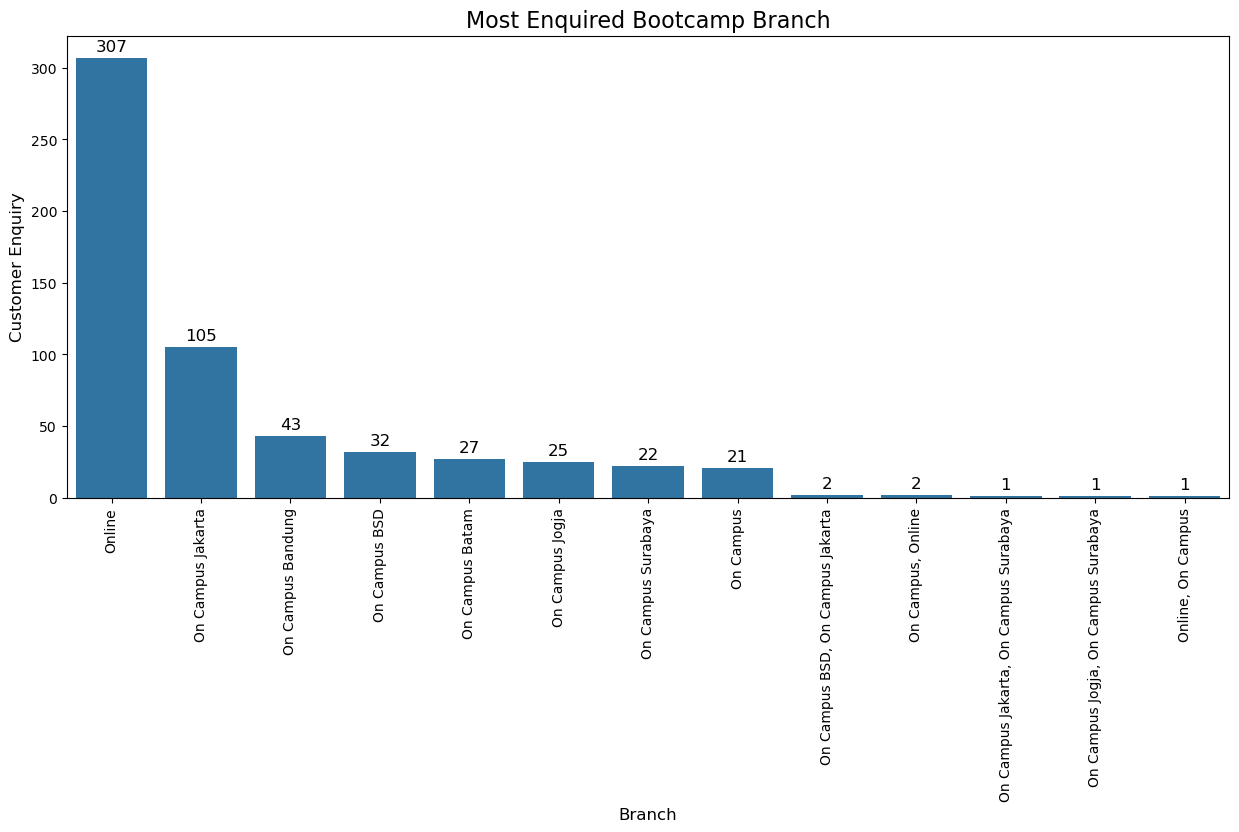

In [932]:
# group by branch
plot1 = df_chat_room.groupby('branch')[['room_id']].count().sort_values(by='room_id', ascending=False).reset_index()

plt.figure(figsize = (15,6))
plt.title('Most Enquired Bootcamp Branch', size = 16)
plots = sns.barplot(data = plot1, x = 'branch', y='room_id')

# annotate label
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
plt.xlabel('Branch', size = 12)
plt.ylabel('Customer Enquiry', size = 12)
plt.xticks(rotation = 90);

***Insight***:
- Kelas *Online* merupakan kelas yang paling diminati oleh calon prospek.
- Kelas *On Campus* Jakarta merupakan kelas berikutnya yang memiliki cukup banyak peminat sebanyak 105 calon prospek.

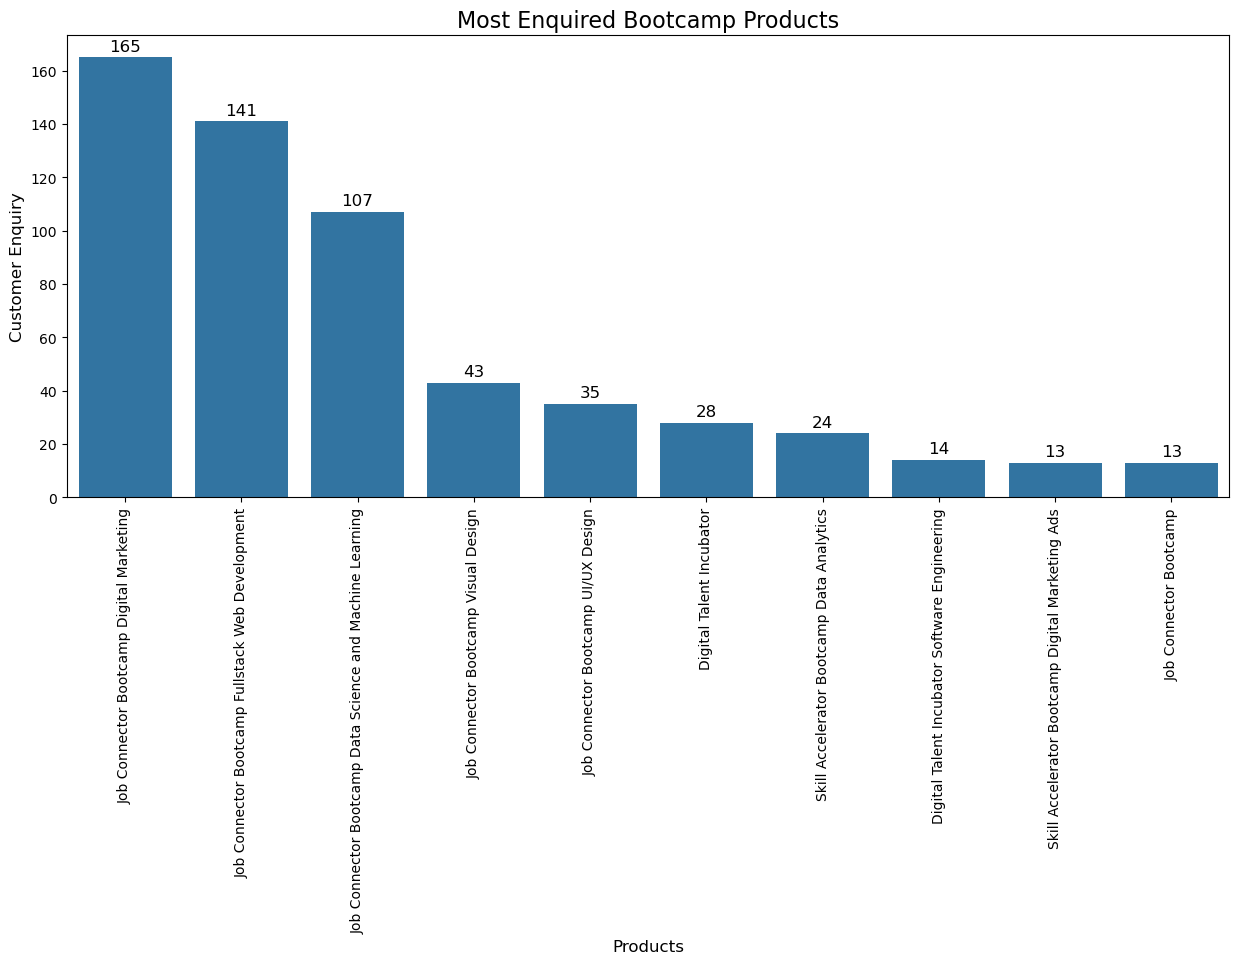

In [933]:
# group by products
plot2 = df_chat_room.groupby('products')[['room_id']].count().sort_values(by='room_id', ascending=False).reset_index().head(10)

plt.figure(figsize = (15,6))
plt.title('Most Enquired Bootcamp Products', size = 16)
plots = sns.barplot(data = plot2, x = 'products', y='room_id')

# annotate label
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
plt.xlabel('Products', size = 12)
plt.ylabel('Customer Enquiry', size = 12)
plt.xticks(rotation = 90);

***Insight***:
- Terdapat 3 produk *bootcamp* yang paling banyak diminati oleh calon prospek:
    1. *Job Connector Bootcamp Digital Marketing*, sebanyak **165 calon prospek**.
    2. *Job Connector Bootcamp Fullstack Web Development*, sebanyak **141 calon prospek**.
    3. *Job Connector Bootcamp Data Science and Machine Learning*, sebanyak **107 calon prospek**.

## ***Data Load***

In [935]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe

# Path to your service account key file
SERVICE_ACCOUNT_FILE = 'customer-enquiry-431809-2ffbd2f82785.json'

# Define the required scopes
SCOPES = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']

# Authenticate and create the service
credentials = ServiceAccountCredentials.from_json_keyfile_name(SERVICE_ACCOUNT_FILE, SCOPES)
gc = gspread.authorize(credentials)

def search_file_in_folder(file_name, folder_id):
    query = f"name = '{file_name}' and '{folder_id}' in parents and trashed = false"
    results = service.files().list(q=query, fields="files(id, name)").execute()
    files = results.get('files', [])
    return files[0] if files else None

# Open the Google Sheet by name or URL
spreadsheet = gc.open("customer enquiry")
worksheet = spreadsheet.sheet1  # Select the first sheet in the Google Sheet

# Clear the worksheet before updating it (optional)
worksheet.clear()

# Upload the DataFrame to Google Sheets
set_with_dataframe(worksheet, df_chat_room)

print("Data uploaded successfully!")

Data uploaded successfully!
